# Project

Waveform plotting. Visualize different aspects. Interactive plotting. Cleanup existing holoviews code.

1. find the exisiting code
2. for a given time:
    - hit pattern
    - sum waveform
    - peak labels
    - channels
    - show 
3. input:
    - run number
    - time
    - curser window?
    
    
straxen.notebooks.experimental.visuallization.py
    

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import strax
export, __all__ = strax.exporter()

In [2]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [3]:
st.data_info('peaks')

Field name        Data type  \
0                channel            int16   
1                     dt            int16   
2                   time            int64   
3                 length            int32   
4                   area          float32   
5       area_per_channel  ('<i4', (248,))   
6                 n_hits            int16   
7                   data  ('<f4', (200,))   
8                  width   ('<f4', (11,))   
9      saturated_channel  ('<i2', (248,))   
10  n_saturated_channels            int16   

                                                                                        Comment  
0                                                                            Channel/PMT number  
1                                                                         Time resolution in ns  
2                                              Start time of the interval (ns since unix epoch)  
3                                                             Length of the interval in samples  
4                                                    Integral across channels in photoelectrons  
5                                               Integral per channel in ADX x samples (not PE!)  
6   Number of hits from which peak was constructed (currently zero if peak is split afterwards)  
7                                                       Waveform data in PE/sample (not PE/ns!)  
8                                             Peak widths in ns: range of central area fraction  
9                                                                 Check if channel is saturated  
10                                                           Total number of saturated channels

In [4]:
st.data_info('peak_basics')

Field name Data type  \
0               time     int64   
1            endtime     int64   
2               area   float32   
3         n_channels     int16   
4            max_pmt     int16   
5       max_pmt_area     int32   
6     range_50p_area   float32   
7  area_fraction_top   float32   
8             length     int32   
9                 dt     int16   

                                               Comment  
0         Start time of the peak (ns since unix epoch)  
1           End time of the peak (ns since unix epoch)  
2                                  Peak integral in PE  
3              Number of PMTs contributing to the peak  
4             PMT number which contributes the most PE  
5  Area of signal in the largest-contributing PMT (PE)  
6    Width (in ns) of the central 50% area of the peak  
7               Fraction of area seen by the top array  
8               Length of the peak waveform in samples  
9           Time resolution of the peak waveform in ns

In [5]:
st.data_info('records')

Field name        Data type  \
0          channel            int16   
1               dt            int16   
2             time            int64   
3           length            int32   
4             area            int32   
5     pulse_length            int32   
6         record_i            int16   
7         baseline          float32   
8  reduction_level            uint8   
9             data  ('<i2', (110,))   

                                                              Comment  
0                                                  Channel/PMT number  
1                                               Time resolution in ns  
2                    Start time of the interval (ns since unix epoch)  
3                                   Length of the interval in samples  
4                                           Integral in ADC x samples  
5  Length of pulse to which the record belongs (without zero-padding)  
6                                        Fragment number in the pulse  
7            Baseline in ADC counts. data = int(baseline) - data_orig  
8         Level of data reduction applied (strax.ReductionLevel enum)  
9                          Waveform data in ADC counts above baseline

In [6]:
st.search_field('*type*')

type is part of peak_classification (provided by PeakClassification)


In [7]:
run_id = '180215_1029'
start_time = st.get_array(run_id, 'peaks')

x = st.get_array(run_id, 'records')
print (np.unique(x['channel']))
t0 = start_time['time'][0]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [16]:
@export
@strax.takes_config(
    strax.Option('s1_max_width', default=150,
                 help="Maximum (IQR) width of S1s"),
    strax.Option('s1_min_n_channels', default=3,
                 help="Minimum number of PMTs that must contribute to a S1"),
    strax.Option('s2_min_area', default=10,
                 help="Minimum area (PE) for S2s"),
    strax.Option('s2_min_width', default=200,
                 help="Minimum width for S2s"))




class AmandaClassification(strax.Plugin):
    """Find lone hits and Single Electrons!"""
    
    # Name of the data type this plugin provides
    provides = 'peak_classification'
    
    # Data types this plugin requires. Note we don't specify
    # what plugins should produce them: maybe the default PeakBasics
    # has been replaced by another AdvancedExpertBlabla plugin?
    depends_on = ('peak_basics',)
    
    # Numpy datatype of the output 
    dtype = straxen.plugins.plugins.PeakClassification.dtype
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.3'

    def compute(self, peaks):
        
        p = peaks
        r = np.zeros(len(p), dtype=self.dtype)
        
        is_s1 = p['n_channels'] >= self.config['s1_min_n_channels']
        is_s1 &= p['range_50p_area'] < self.config['s1_max_width']
        r['type'][is_s1] = 1

        is_s2 = p['area'] > self.config['s2_min_area']
        is_s2 &= p['range_50p_area'] > self.config['s2_min_width']
        r['type'][is_s2] = 2

        is_lh = p['n_channels'] == 1
        r['type'][is_lh] = 3
        
        is_se = p['area'] > 10
        is_se &= p['area'] < 50
        is_se &= p['range_50p_area'] > 1e2
        is_se &= p['range_50p_area'] < 5e2
        r['type'][is_se] = 4
        
        is_de = p['area'] > 40
        is_de &= p['area'] < 80
        is_de &= p['range_50p_area'] > 8.5e2
        is_de &= p['range_50p_area'] < 4.5e3
        r['type'][is_de] = 5
        

        
        return r

In [17]:
st.register(AmandaClassification)

__main__.AmandaClassification

In [70]:
"""Plotting helper functions for the online demo notebook
The code in show_time_range is mostly copy-pasted from 
the visualization notebook.
"""
import time
import numpy as np
import matplotlib.pyplot as plt
from straxen import units

def event_scatter(df, sleep_factor=2, max_delay=60, time_cut=False, s=5, update=False):
    max_delay *= 1e9

    # Select recent events
    if time_cut:
        now = time.time()
        df['delay'] = int(now) * int(1e9) - df['time']
        df = df[df['delay'] < int(max_delay)]
        s = 200 * (max_delay - df.delay) / max_delay
    else:
        s = s
        if len(df) > 10000:
            df = df.sample(10000)

    # Update the plot
    plt.gca().clear()

    plt.scatter(np.nan_to_num(df.cs1),
                np.nan_to_num(df.cs2),
                c=df.s1_area_fraction_top,
                vmin=0, vmax=0.3,
                s=s,
                cmap=plt.cm.jet,
                marker='.', edgecolors='none')
    if not update:
        plt.colorbar(label="S1 area fraction top", extend='max')
    plt.xlabel('cS1 (PE)')
    plt.ylabel('cS2 (PE)')
    plt.xscale('symlog')
    plt.yscale('log')
    plt.ylim(1e1, 1e7)
    plt.xlim(-0.1, 1e6)
    if time_cut:
        plt.title(time.strftime('%H:%M:%S'))

    plt.gcf().canvas.draw()

    if time_cut:
        # Sleep for some fraction of the time it took to make the plot
        time.sleep(sleep_factor * (time.time() - now))



def show_time_range(st, run_id, t0, dt):
    from functools import partial

    import numpy as np
    import pandas as pd

    import holoviews as hv
    from holoviews.operation.datashader import datashade, dynspread
    hv.extension('bokeh')
    #hv.extension('matplotlib')


    import strax

    import gc
    # Somebody thought it was a good idea to call gc.collect explicitly somewhere in holoviews
    # This makes dynamic PMT maps super slow
    # Until I trace the offender:
    gc.collect = lambda *args, **kwargs: None

    # Custom wheel zoom tool that only zooms in time
    from bokeh.models import WheelZoomTool
    time_zoom = WheelZoomTool(dimensions='width')

    
    # Get ADC->pe multiplicative conversion factor without PAX
    from straxen.common import get_to_pe
    to_pe = get_to_pe(run_id, 'https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/master/to_pe.npy')
    #print (len(to_pe))
    
    
    # Get ADC->pe multiplicative conversion factor with PAX
    #from pax.configuration import load_configuration
    #from pax.dsputils import adc_to_pe
    #pax_config = load_configuration('XENON1T')["DEFAULT"]
    #to_pe = np.array([adc_to_pe(pax_config, ch)
    #                  for ch in range(pax_config['n_channels'])])

    #!!!!tpc_r = pax_config['tpc_radius']
    
    
    # Get PMT positions from the XENON1T config wihtout PAX
    from ast import literal_eval
    import configparser
    import straxen
    config = configparser.ConfigParser()
    config.read_string(
        straxen.get_resource('https://raw.githubusercontent.com/XENON1T/pax/master/pax/config/XENON1T.ini'))
    pmt_positions = np.array([(dict(x=q['position']['x'], y=q['position']['y'], i=q['pmt_position'], array=q.get('array','other')))
        for q in literal_eval(config['DEFAULT']['pmts'])])[:248]
    
    tpc_r = float(config['DEFAULT']['tpc_radius'][:4])
    
    r = []
    for x in pmt_positions:
        r.append(x)
    
    pmt_locs = pd.DataFrame(r)
    
    #print (pmt_locs)
    
    #array = pmt_locs[array].values
    #print (array)
    
    # Get locations of PMTs with PAX
    #r = []
    #for q in pax_config['pmts']:
    #    r.append(dict(x=q['position']['x'],
    #                  y=q['position']['y'],
    #                  i=q['pmt_position'],
    #                  array=q.get('array', 'other')))
    f = 1.08
    #pmt_locs = pd.DataFrame(r)

    #records = st.get_array(run_id, 'raw_records', time_range=(t0, t0 + int(1e10)))
    records = st.get_array(run_id, 'records', time_range=(t0, t0 + int(1e10)))
    
    
    
    # TOOD: don't reprocess, just load...
    #hits = strax.find_hits(records)
    #peaks = strax.find_peaks(hits, to_pe, gap_threshold=300, min_hits=3,
    #                         result_dtype=strax.peak_dtype(n_channels=248))
    
    
    #print (len(records['data'].sum(axis=1)))
    #print (np.sort(records['channel']))


    
    peaks = st.get_array(run_id,['peaks','peak_basics','peak_classification'],
                         register=AmandaClassification, 
                         config=dict(s2_tail_veto=False))
    peaks = peaks[(peaks['time'] > t0) & (peaks['time'] < t0+int(1e10))]
    #peaks = st.get_df(run_id,'peak_basics',config=dict(s2_tail_veto=False))
    #p_type = st.get_df(run_id,'peak_classification')
    #p_type = st.get_df(run_id,'AmandaClassification')
    
    
    #print (len(peaks))
    #print (len(p_type))
    
    
    #strax.sum_waveform(peaks, records, to_pe)
    
    
    
    # Integral in pe
    areas_r = records['data'].sum(axis=1) * to_pe[records['channel']]
    areas = peaks['area']

    def normalize_time(t):
        return (t - peaks[0]['time']) / 1e9

    # Create dataframe with record metadata
    df = pd.DataFrame(dict(area=areas_r,
                           time=normalize_time(records['time']),
                           channel=records['channel']))

    # Convert to holoviews Points
    points = hv.Points(df,
                       kdims=[hv.Dimension('time', label='Time', unit='sec'),
                              hv.Dimension('channel', label='PMT number', range=(0, 248))],
                       vdims=[hv.Dimension('area', label='Area', unit='pe',
                                           # range=(0, 1000)
                                           )])

    def pmt_map(t_0, t_1, array='top', **kwargs):
        # Compute the PMT pattern (fast)
        ps = points[(t_0 <= points['time'])
                    & (points['time'] < t_1)]
        areas = np.bincount(ps['channel'],
                            weights=ps['area'],
                            minlength=len(pmt_locs))

        # Which PMTs should we include?
        pmt_mask = pmt_locs['array'] == array
        d = pmt_locs[pmt_mask].copy()
        d['area'] = areas[pmt_mask]

        # Convert to holoviews points
        d = hv.Dataset(d,
                       kdims=[hv.Dimension('x', unit='cm', range=(-tpc_r * f, tpc_r * f)),
                              hv.Dimension('y', unit='cm', range=(-tpc_r * f, tpc_r * f)),
                              hv.Dimension('i', label='PMT number'),
                              hv.Dimension('area',
                                           label='Area',
                                           unit='PE')])

        return d.to(hv.Points,
                    vdims=['area', 'i'],
                    group='PMTPattern',
                    label=array.capitalize(),
                    **kwargs).opts(
            plot=dict(color_index=2,
                      tools=['hover'],
                      show_grid=False),
            style=dict(size=17,
                       cmap='plasma'))

    def pmt_map_range(x_range, array='top', **kwargs):
        # For use in dynamicmap with streams
        if x_range is None:
            x_range = (0, 0)
        return pmt_map(x_range[0], x_range[1], array=array, **kwargs)

    xrange_stream = hv.streams.RangeX(source=points)

    # TODO: weigh by area

    def channel_map():
        return dynspread(datashade(points,
                                   y_range=(0, 260),
                                   streams=[xrange_stream])).opts(
            plot=dict(width=600,
                      tools=[time_zoom, 'xpan'],
                      default_tools=['save', 'pan', 'box_zoom', 'save', 'reset'],
                      show_grid=False))

    
    #peak labels
#     def classification(ps):


#         p1 = ps
#         r = np.zeros(len(p1), dtype=np.int8)
        
#         #is_s1 = p1['n_channels'] >= config['s1_min_n_channels']
#         #is_s1 &= p1['range_50p_area'] < config['s1_max_width']
#         #r['type'][is_s1] = 1

#         #is_s2 = p1['area'] > config['s2_min_area']
#         #is_s2 &= p1['range_50p_area'] > config['s2_min_width']
#         #r['type'][is_s2] = 2

#         #is_lh = (p1['n_channels'] == 1)
#         #print (is_lh)
#         #r['type'][is_lh] = 3
        
#         is_se = (p1['area'] > 10)
#         is_se &= (p1['area'] < 50)
#         is_se &= (p1['range_50p_area'] > 1e2)
#         is_se &= (p1['range_50p_area'] < 5e2)
#         r['type'][is_se] = 4
        
#         is_de = (p1['area'] > 40)
#         is_de &= (p1['area'] < 80)
#         is_de &= (p1['range_50p_area'] > 8.5e2)
#         is_de &= (p1['range_50p_area'] < 4.5e3)
#         r['type'][is_de] = 5
    
        
#         return r
    
    
    
    from holoviews import opts

    def plot_peak(p):
    #def plot_peak(p,r):
        # It's better to plot amplitude /time than per bin, since
        # sampling times are now variable
        y = p['data'][:p['length']] / p['dt']
        t_edges = np.arange(p['length'] + 1, dtype=np.int64)
        t_edges = t_edges * p['dt'] + p['time']
        t_edges = normalize_time(t_edges)

        # Correct step plotting from Knut
        t_ = np.zeros(2 * len(y))
        y_ = np.zeros(2 * len(y))
        l_ = np.zeros(2 * len(y))
        
        t_[0::2] = t_edges[0:-1]
        t_[1::2] = t_edges[1::]
        
        y_[0::2] = y
        y_[1::2] = y
        
        l_ = p['type']

        #print (len(y))
        #print (len(t_))
        #print (len(y_))
        #print ((l_))
        
        
        l = []
        if p['type'] == 1:
            colors = 'r'
            l.append('s1')
        elif p['type'] == 2:
            colors = 'b'
            l.append('s2')
        elif p['type'] == 3:
            colors = 'g'
            l.append('lone_hit')
        elif p['type'] == 4:
            colors = 'c'
            l.append('se')
        elif p['type'] == 5:
            colors = 'm'
            l.append('de')
        else:
            colors = 'k'
            l.append('unknown')
        
        
        
        
        c = hv.Curve(dict(time=t_, amplitude=y_),
                     kdims=points.kdims[0],
                     vdims=hv.Dimension('amplitude', label='Amplitude', unit='PE/ns'),
                     group='PeakSumWaveform')
        #labels = hv.Labels(points.kdims[0],p_type)

        
        labels = hv.Labels({'x' : t_, 'y': y_, 'text': l}, ['x', 'y'], 'text')


        
        
        return c.opts(
        #return (c* labels).opts(
            plot=dict(  # interpolation='steps-mid',
            # default_tools=['save', 'pan', 'box_zoom', 'save', 'reset'],
            # tools=[time_zoom, 'xpan'],
            width=600,
            shared_axes=False,
            show_grid=True),
            style=dict(color=colors)
            # norm=dict(framewise=True)
        )
# #         c_opts = opts.Curve(line_color='c', width=600)
# #         #l_opts = opts.Labels(text_color='k')
#         #return c.opts(
#         #return (c* labels).opts(
# #             plot=dict(  # interpolation='steps-mid',
# #             # default_tools=['save', 'pan', 'box_zoom', 'save', 'reset'],
# #             # tools=[time_zoom, 'xpan'],
# #             width=600,
# #             shared_axes=False,
# #             show_grid=True),
# #             style=dict(color=colors)
# #             # norm=dict(framewise=True)
# #         )
# #         layout = c #+ labels
# #         layout.opts(c_opts)#, l_opts)
#             opts.Curve(plot=dict(
#                 width=600,
#                 #fig_size=600,
#                 shared_axes=True,
#                 show_grid=True),
#                 gridstyle=dict(color=colors)),
#             opts.Labels(text_color='k')
        
#         )
    
    
# #         return c.opts(
# #             plot=dict(
# #             width=600,
# #             #fig_size=600,
# #             shared_axes=True,
# #             show_grid=True),
# #             style=dict(color=colors)
# #             # norm=dict(framewise=True)
# #         ) + labels.opts(text_color='k')
    
    
    
    def peaks_in(t_0, t_1):
        #return peaks[(normalize_time(peaks['time'] + peaks['length'] * peaks['dt']) > t_0)
        return peaks[(normalize_time(peaks['time'] + peaks['endtime']) > t_0)
                     & (normalize_time(peaks['time']) < t_1)]

#         # Find peaks in this range
#         ps = peaks_in(t_0, t_1)
#         # Show only the largest n_max peaks
#         if len(ps) > n_max:
#             areas = ps['area']
#             max_area = np.sort(areas)[-n_max]
#             ps = ps[areas >= max_area]
#         r = classification(ps)


#         return hv.Overlay(items=[plot_peak(p,r) for p in ps])

    def plot_peaks(t_0, t_1, n_max=100):
        # Find peaks in this range
        ps = peaks_in(t_0, t_1)
        # Show only the largest n_max peaks
        if len(ps) > n_max:
            areas = ps['area']
            max_area = np.sort(areas)[-n_max]
            ps = ps[areas >= max_area]
        #r = classification(ps)

        return hv.Overlay(items=[plot_peak(p) for p in ps])
        #return hv.Overlay(items=[plot_peak(p,r) for p in ps])


#     def plot_peaks(t_0, t_1, n_max=10):
#         # Find peaks in this range
#         ps = peaks_in(t_0, t_1)
#         # Show only the largest n_max peaks
#         if len(ps) > n_max:
#             s1s = ps['type'] == 1
#             s2s = ps['type'] == 2
#             ses = ps['type'] == 4
#             s1 = ps['area'][s1s]
#             s2 = ps['area'][s2s]
#             se = ps['area'][ses]
#             maxs1_area = np.sort(s1)[-n_max]
#             choices1 = ps['area'] > maxs1_area
#             choices1 &= s1s
#             maxs2_area = np.sort(s2)[-n_max]
#             choices2 = ps['area'] > maxs2_area
#             choices2 &= s2s
#             maxse_area = np.sort(se)[-n_max]
#             choices4 = ps['area'] > maxse_area
#             choices4 &= ses
            
#             fullchoice = choices1 | choices2 | choices4
#             ps = ps[fullchoice]
#         #r = classification(ps)

#         return hv.Overlay(items=[plot_peak(p) for p in ps])
    
    
    def plot_peak_range(x_range, **kwargs):
        # For use in dynamicmap with streams
        if x_range is None:
            x_range = (0, 10)
        return plot_peaks(x_range[0], x_range[1], **kwargs)


    top_map = hv.DynamicMap(partial(pmt_map_range, array='top'), streams=[xrange_stream])
    bot_map = hv.DynamicMap(partial(pmt_map_range, array='bottom'), streams=[xrange_stream])
    waveform = hv.DynamicMap(plot_peak_range, streams=[xrange_stream])
    layout = waveform + top_map + channel_map() + bot_map
    return layout.cols(2)

In [71]:
"""Plotting helper functions for the online demo notebook
The code in show_time_range is mostly copy-pasted from 
the visualization notebook.
"""
import time
import numpy as np
import matplotlib.pyplot as plt
from straxen import units

def event_scatter(df, sleep_factor=2, max_delay=60, time_cut=False, s=5, update=False):
    max_delay *= 1e9

    # Select recent events
    if time_cut:
        now = time.time()
        df['delay'] = int(now) * int(1e9) - df['time']
        df = df[df['delay'] < int(max_delay)]
        s = 200 * (max_delay - df.delay) / max_delay
    else:
        s = s
        if len(df) > 10000:
            df = df.sample(10000)

    # Update the plot
    plt.gca().clear()

    plt.scatter(np.nan_to_num(df.cs1),
                np.nan_to_num(df.cs2),
                c=df.s1_area_fraction_top,
                vmin=0, vmax=0.3,
                s=s,
                cmap=plt.cm.jet,
                marker='.', edgecolors='none')
    if not update:
        plt.colorbar(label="S1 area fraction top", extend='max')
    plt.xlabel('cS1 (PE)')
    plt.ylabel('cS2 (PE)')
    plt.xscale('symlog')
    plt.yscale('log')
    plt.ylim(1e1, 1e7)
    plt.xlim(-0.1, 1e6)
    if time_cut:
        plt.title(time.strftime('%H:%M:%S'))

    plt.gcf().canvas.draw()

    if time_cut:
        # Sleep for some fraction of the time it took to make the plot
        time.sleep(sleep_factor * (time.time() - now))



def show_time_range2(st, run_id, t0, dt):
    from functools import partial

    import numpy as np
    import pandas as pd

    import holoviews as hv
    from holoviews.operation.datashader import datashade, dynspread
    hv.extension('bokeh')
    #hv.extension('matplotlib')


    import strax

    import gc
    # Somebody thought it was a good idea to call gc.collect explicitly somewhere in holoviews
    # This makes dynamic PMT maps super slow
    # Until I trace the offender:
    gc.collect = lambda *args, **kwargs: None

    # Custom wheel zoom tool that only zooms in time
    from bokeh.models import WheelZoomTool
    time_zoom = WheelZoomTool(dimensions='width')

    
    # Get ADC->pe multiplicative conversion factor without PAX
    from straxen.common import get_to_pe
    to_pe = get_to_pe(run_id, 'https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/master/to_pe.npy')
    #print (len(to_pe))
    
    
    # Get ADC->pe multiplicative conversion factor with PAX
    #from pax.configuration import load_configuration
    #from pax.dsputils import adc_to_pe
    #pax_config = load_configuration('XENON1T')["DEFAULT"]
    #to_pe = np.array([adc_to_pe(pax_config, ch)
    #                  for ch in range(pax_config['n_channels'])])

    #!!!!tpc_r = pax_config['tpc_radius']
    
    
    # Get PMT positions from the XENON1T config wihtout PAX
    from ast import literal_eval
    import configparser
    import straxen
    config = configparser.ConfigParser()
    config.read_string(
        straxen.get_resource('https://raw.githubusercontent.com/XENON1T/pax/master/pax/config/XENON1T.ini'))
    pmt_positions = np.array([(dict(x=q['position']['x'], y=q['position']['y'], i=q['pmt_position'], array=q.get('array','other')))
        for q in literal_eval(config['DEFAULT']['pmts'])])[:248]
    
    tpc_r = float(config['DEFAULT']['tpc_radius'][:4])
    
    r = []
    for x in pmt_positions:
        r.append(x)
    
    pmt_locs = pd.DataFrame(r)
    
    #print (pmt_locs)
    
    #array = pmt_locs[array].values
    #print (array)
    
    # Get locations of PMTs with PAX
    #r = []
    #for q in pax_config['pmts']:
    #    r.append(dict(x=q['position']['x'],
    #                  y=q['position']['y'],
    #                  i=q['pmt_position'],
    #                  array=q.get('array', 'other')))
    f = 1.08
    #pmt_locs = pd.DataFrame(r)

    #records = st.get_array(run_id, 'raw_records', time_range=(t0, t0 + int(1e10)))
    records = st.get_array(run_id, 'records', time_range=(t0, t0 + int(1e10)))
    
    
    
    # TOOD: don't reprocess, just load...
    #hits = strax.find_hits(records)
    #peaks = strax.find_peaks(hits, to_pe, gap_threshold=300, min_hits=3,
    #                         result_dtype=strax.peak_dtype(n_channels=248))
    
    
    #print (len(records['data'].sum(axis=1)))
    #print (np.sort(records['channel']))


    
    peaks = st.get_array(run_id,['peaks','peak_basics','peak_classification'],
                         register=AmandaClassification, 
                         config=dict(s2_tail_veto=False))
    peaks = peaks[(peaks['time'] > t0) & (peaks['time'] < t0+int(1e10))]
    #peaks = st.get_df(run_id,'peak_basics',config=dict(s2_tail_veto=False))
    #p_type = st.get_df(run_id,'peak_classification')
    #p_type = st.get_df(run_id,'AmandaClassification')
    
    
    #print (len(peaks))
    #print (len(p_type))
    
    
    #strax.sum_waveform(peaks, records, to_pe)
    
    
    
    # Integral in pe
    areas_r = records['data'].sum(axis=1) * to_pe[records['channel']]
    areas = peaks['area']

    def normalize_time(t):
        return (t - peaks[0]['time']) / 1e9

    # Create dataframe with record metadata
    df = pd.DataFrame(dict(area=areas_r,
                           time=normalize_time(records['time']),
                           channel=records['channel']))

    # Convert to holoviews Points
    points = hv.Points(df,
                       kdims=[hv.Dimension('time', label='Time', unit='sec'),
                              hv.Dimension('channel', label='PMT number', range=(0, 248))],
                       vdims=[hv.Dimension('area', label='Area', unit='pe',
                                           # range=(0, 1000)
                                           )])

    def pmt_map(t_0, t_1, array='top', **kwargs):
        # Compute the PMT pattern (fast)
        ps = points[(t_0 <= points['time'])
                    & (points['time'] < t_1)]
        areas = np.bincount(ps['channel'],
                            weights=ps['area'],
                            minlength=len(pmt_locs))

        # Which PMTs should we include?
        pmt_mask = pmt_locs['array'] == array
        d = pmt_locs[pmt_mask].copy()
        d['area'] = areas[pmt_mask]

        # Convert to holoviews points
        d = hv.Dataset(d,
                       kdims=[hv.Dimension('x', unit='cm', range=(-tpc_r * f, tpc_r * f)),
                              hv.Dimension('y', unit='cm', range=(-tpc_r * f, tpc_r * f)),
                              hv.Dimension('i', label='PMT number'),
                              hv.Dimension('area',
                                           label='Area',
                                           unit='PE')])

        return d.to(hv.Points,
                    vdims=['area', 'i'],
                    group='PMTPattern',
                    label=array.capitalize(),
                    **kwargs).opts(
            plot=dict(color_index=2,
                      tools=['hover'],
                      show_grid=False),
            style=dict(size=17,
                       cmap='plasma'))

    def pmt_map_range(x_range, array='top', **kwargs):
        # For use in dynamicmap with streams
        if x_range is None:
            x_range = (0, 0)
        return pmt_map(x_range[0], x_range[1], array=array, **kwargs)

    xrange_stream = hv.streams.RangeX(source=points)

    # TODO: weigh by area

    def channel_map():
        return dynspread(datashade(points,
                                   y_range=(0, 260),
                                   streams=[xrange_stream])).opts(
            plot=dict(width=600,
                      tools=[time_zoom, 'xpan'],
                      default_tools=['save', 'pan', 'box_zoom', 'save', 'reset'],
                      show_grid=False))

    
    #peak labels
#     def classification(ps):


#         p1 = ps
#         r = np.zeros(len(p1), dtype=np.int8)
        
#         #is_s1 = p1['n_channels'] >= config['s1_min_n_channels']
#         #is_s1 &= p1['range_50p_area'] < config['s1_max_width']
#         #r['type'][is_s1] = 1

#         #is_s2 = p1['area'] > config['s2_min_area']
#         #is_s2 &= p1['range_50p_area'] > config['s2_min_width']
#         #r['type'][is_s2] = 2

#         #is_lh = (p1['n_channels'] == 1)
#         #print (is_lh)
#         #r['type'][is_lh] = 3
        
#         is_se = (p1['area'] > 10)
#         is_se &= (p1['area'] < 50)
#         is_se &= (p1['range_50p_area'] > 1e2)
#         is_se &= (p1['range_50p_area'] < 5e2)
#         r['type'][is_se] = 4
        
#         is_de = (p1['area'] > 40)
#         is_de &= (p1['area'] < 80)
#         is_de &= (p1['range_50p_area'] > 8.5e2)
#         is_de &= (p1['range_50p_area'] < 4.5e3)
#         r['type'][is_de] = 5
    
        
#         return r
    
    
    
    from holoviews import opts

    def plot_peak(p):
    #def plot_peak(p,r):
        # It's better to plot amplitude /time than per bin, since
        # sampling times are now variable
        y = p['data'][:p['length']] / p['dt']
        t_edges = np.arange(p['length'] + 1, dtype=np.int64)
        t_edges = t_edges * p['dt'] + p['time']
        t_edges = normalize_time(t_edges)

        # Correct step plotting from Knut
        t_ = np.zeros(2 * len(y))
        y_ = np.zeros(2 * len(y))
        l_ = np.zeros(2 * len(y))
        
        t_[0::2] = t_edges[0:-1]
        t_[1::2] = t_edges[1::]
        
        y_[0::2] = y
        y_[1::2] = y
        
        l_ = p['type']

        #print (len(y))
        #print (len(t_))
        #print (len(y_))
        #print ((l_))
        
        
        l = []
        if p['type'] == 1:
            colors = 'r'
            l.append('s1')
        elif p['type'] == 2:
            colors = 'b'
            l.append('s2')
        elif p['type'] == 3:
            colors = 'g'
            l.append('lone_hit')
        elif p['type'] == 4:
            colors = 'c'
            l.append('se')
        elif p['type'] == 5:
            colors = 'm'
            l.append('de')
        else:
            colors = 'k'
            l.append('unknown')
        
        
        
        
        c = hv.Curve(dict(time=t_, amplitude=y_),
                     kdims=points.kdims[0],
                     vdims=hv.Dimension('amplitude', label='Amplitude', unit='PE/ns'),
                     group='PeakSumWaveform')
        #labels = hv.Labels(points.kdims[0],p_type)

        
        labels = hv.Labels({'x' : t_, 'y': y_, 'text': l}, ['x', 'y'], 'text')


#         c_opts = opts.Curve(line_color='c', width=600)
#         #l_opts = opts.Labels(text_color='k')
        #return c.opts(
        return (c* labels).opts(
            plot=dict(  # interpolation='steps-mid',
            # default_tools=['save', 'pan', 'box_zoom', 'save', 'reset'],
            # tools=[time_zoom, 'xpan'],
            width=600,
            shared_axes=False,
            show_grid=True),
            style=dict(color=colors)
            # norm=dict(framewise=True)
        )
#         layout = c #+ labels
#         layout.opts(c_opts)#, l_opts)
#             opts.Curve(plot=dict(
#                 width=600,
#                 #fig_size=600,
#                 shared_axes=True,
#                 show_grid=True),
#                 gridstyle=dict(color=colors)),
#             opts.Labels(text_color='k')
        
#         )
    
    
#         return c.opts(
#             plot=dict(
#             width=600,
#             #fig_size=600,
#             shared_axes=True,
#             show_grid=True),
#             style=dict(color=colors)
#             # norm=dict(framewise=True)
#         ) + labels.opts(text_color='k')
    
    
    
    def peaks_in(t_0, t_1):
        #return peaks[(normalize_time(peaks['time'] + peaks['length'] * peaks['dt']) > t_0)
        return peaks[(normalize_time(peaks['time'] + peaks['endtime']) > t_0)
                     & (normalize_time(peaks['time']) < t_1)]

#         # Find peaks in this range
#         ps = peaks_in(t_0, t_1)
#         # Show only the largest n_max peaks
#         if len(ps) > n_max:
#             areas = ps['area']
#             max_area = np.sort(areas)[-n_max]
#             ps = ps[areas >= max_area]
#         r = classification(ps)


#         return hv.Overlay(items=[plot_peak(p,r) for p in ps])

    def plot_peaks(t_0, t_1, n_max=100):
        # Find peaks in this range
        ps = peaks_in(t_0, t_1)
        # Show only the largest n_max peaks
        if len(ps) > n_max:
            areas = ps['area']
            max_area = np.sort(areas)[-n_max]
            ps = ps[areas >= max_area]
        #r = classification(ps)

        return hv.Overlay(items=[plot_peak(p) for p in ps])
        #return hv.Overlay(items=[plot_peak(p,r) for p in ps])


#     def plot_peaks(t_0, t_1, n_max=10):
#         # Find peaks in this range
#         ps = peaks_in(t_0, t_1)
#         # Show only the largest n_max peaks
#         if len(ps) > n_max:
#             s1s = ps['type'] == 1
#             s2s = ps['type'] == 2
#             ses = ps['type'] == 4
#             s1 = ps['area'][s1s]
#             s2 = ps['area'][s2s]
#             se = ps['area'][ses]
#             maxs1_area = np.sort(s1)[-n_max]
#             choices1 = ps['area'] > maxs1_area
#             choices1 &= s1s
#             maxs2_area = np.sort(s2)[-n_max]
#             choices2 = ps['area'] > maxs2_area
#             choices2 &= s2s
#             maxse_area = np.sort(se)[-n_max]
#             choices4 = ps['area'] > maxse_area
#             choices4 &= ses
            
#             fullchoice = choices1 | choices2 | choices4
#             ps = ps[fullchoice]
#         #r = classification(ps)

#         return hv.Overlay(items=[plot_peak(p) for p in ps])
    
    
    def plot_peak_range(x_range, **kwargs):
        # For use in dynamicmap with streams
        if x_range is None:
            x_range = (0, 10)
        return plot_peaks(x_range[0], x_range[1], **kwargs)


    top_map = hv.DynamicMap(partial(pmt_map_range, array='top'), streams=[xrange_stream])
    bot_map = hv.DynamicMap(partial(pmt_map_range, array='bottom'), streams=[xrange_stream])
    waveform = hv.DynamicMap(plot_peak_range, streams=[xrange_stream])
    layout = waveform + top_map + channel_map() + bot_map
    return layout.cols(2)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
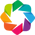

Not saving records while selecting a time range in the run


:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .PeakSumWaveform.I        :Curve   [time]   (amplitude)
         .PeakSumWaveform.II       :Curve   [time]   (amplitude)
         .PeakSumWaveform.III      :Curve   [time]   (amplitude)
         .PeakSumWaveform.IV       :Curve   [time]   (amplitude)
         .PeakSumWaveform.V        :Curve   [time]   (amplitude)
         .PeakSumWaveform.VI       :Curve   [time]   (amplitude)
         .PeakSumWaveform.VII      :Curve   [time]   (amplitude)
         .PeakSumWaveform.VIII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.IX       :Curve   [time]   (amplitude)
         .PeakSumWaveform.X        :Curve   [time]   (amplitude)
         .PeakSumWaveform.XI       :Curve   [time]   (amplitude)
         .PeakSumWaveform.XII      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XIII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XIV      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XV       :Curve   [time]   (amplitude)
         .PeakSumWaveform.XVI      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XVII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XVIII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XIX      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XX       :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXI      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXIII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXIV     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXV      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXVI     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXVII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXVIII   :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXIX     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXX      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXI     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXIII   :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXIV    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXV     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXVI    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXVII   :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXVIII  :Curve   [time]   (amplitude)
         .PeakSumWaveform.XXXIX    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XL       :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLI      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLIII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLIV     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLV      :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLVI     :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLVII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLVIII   :Curve   [time]   (amplitude)
         .PeakSumWaveform.XLIX     :Curve   [time]   (amplitude)
         .PeakSumWaveform.L        :Curve   [time]   (amplitude)
         .PeakSumWaveform.LI       :Curve   [time]   (amplitude)
         .PeakSumWaveform.LII      :Curve   [time]   (amplitude)
         .PeakSumWaveform.LIII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.LIV      :Curve   [time]   (amplitude)
         .PeakSumWaveform.LV       :Curve   [time]   (amplitude)
         .PeakSumWaveform.LVI      :Curve   [time]   (amplitude)
         .PeakSumWaveform.LVII     :Curve   [time]   (amplitude)
         .PeakSumWaveform.LVIII    :Curve   [time]   (amplitude)
         .PeakSumWaveform.LIX      :Curve   [time]   (amplitude)
         .PeakSumWaveform.LX       :Curve   [time]   (amplitude)
         .PeakSumWaveform.LXI      :Curve

In [72]:
show_time_range(st, run_id, t0, 10)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
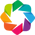

Not saving records while selecting a time range in the run


:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .PeakSumWaveform.I        :Curve   [time]   (amplitude)
         .Labels.I                 :Labels   [x,y]   (text)
         .PeakSumWaveform.II       :Curve   [time]   (amplitude)
         .Labels.II                :Labels   [x,y]   (text)
         .PeakSumWaveform.III      :Curve   [time]   (amplitude)
         .Labels.III               :Labels   [x,y]   (text)
         .PeakSumWaveform.IV       :Curve   [time]   (amplitude)
         .Labels.IV                :Labels   [x,y]   (text)
         .PeakSumWaveform.V        :Curve   [time]   (amplitude)
         .Labels.V                 :Labels   [x,y]   (text)
         .PeakSumWaveform.VI       :Curve   [time]   (amplitude)
         .Labels.VI                :Labels   [x,y]   (text)
         .PeakSumWaveform.VII      :Curve   [time]   (amplitude)
         .Labels.VII               :Labels   [x,y]   (text)
         .PeakSumWaveform.VIII     :Curve   [time]   (amplitude)
         .Labels.VIII              :Labels   [x,y]   (text)
         .PeakSumWaveform.IX       :Curve   [time]   (amplitude)
         .Labels.IX                :Labels   [x,y]   (text)
         .PeakSumWaveform.X        :Curve   [time]   (amplitude)
         .Labels.X                 :Labels   [x,y]   (text)
         .PeakSumWaveform.XI       :Curve   [time]   (amplitude)
         .Labels.XI                :Labels   [x,y]   (text)
         .PeakSumWaveform.XII      :Curve   [time]   (amplitude)
         .Labels.XII               :Labels   [x,y]   (text)
         .PeakSumWaveform.XIII     :Curve   [time]   (amplitude)
         .Labels.XIII              :Labels   [x,y]   (text)
         .PeakSumWaveform.XIV      :Curve   [time]   (amplitude)
         .Labels.XIV               :Labels   [x,y]   (text)
         .PeakSumWaveform.XV       :Curve   [time]   (amplitude)
         .Labels.XV                :Labels   [x,y]   (text)
         .PeakSumWaveform.XVI      :Curve   [time]   (amplitude)
         .Labels.XVI               :Labels   [x,y]   (text)
         .PeakSumWaveform.XVII     :Curve   [time]   (amplitude)
         .Labels.XVII              :Labels   [x,y]   (text)
         .PeakSumWaveform.XVIII    :Curve   [time]   (amplitude)
         .Labels.XVIII             :Labels   [x,y]   (text)
         .PeakSumWaveform.XIX      :Curve   [time]   (amplitude)
         .Labels.XIX               :Labels   [x,y]   (text)
         .PeakSumWaveform.XX       :Curve   [time]   (amplitude)
         .Labels.XX                :Labels   [x,y]   (text)
         .PeakSumWaveform.XXI      :Curve   [time]   (amplitude)
         .Labels.XXI               :Labels   [x,y]   (text)
         .PeakSumWaveform.XXII     :Curve   [time]   (amplitude)
         .Labels.XXII              :Labels   [x,y]   (text)
         .PeakSumWaveform.XXIII    :Curve   [time]   (amplitude)
         .Labels.XXIII             :Labels   [x,y]   (text)
         .PeakSumWaveform.XXIV     :Curve   [time]   (amplitude)
         .Labels.XXIV              :Labels   [x,y]   (text)
         .PeakSumWaveform.XXV      :Curve   [time]   (amplitude)
         .Labels.XXV               :Labels   [x,y]   (text)
         .PeakSumWaveform.XXVI     :Curve   [time]   (amplitude)
         .Labels.XXVI              :Labels   [x,y]   (text)
         .PeakSumWaveform.XXVII    :Curve   [time]   (amplitude)
         .Labels.XXVII             :Labels   [x,y]   (text)
         .PeakSumWaveform.XXVIII   :Curve   [time]   (amplitude)
         .Labels.XXVIII            :Labels   [x,y]   (text)
         .PeakSumWaveform.XXIX     :Curve   [time]   (amplitude)
         .Labels.XXIX              :Labels   [x,y]   (text)
         .PeakSumWaveform.XXX      :Curve   [time]   (amplitude)
         .Labels.XXX               :Labels   [x,y]   (text)
         .PeakSumWaveform.XXXI     :Curve   [time]   (amplitude)
         .Labels.XXXI              :Labels   [x,y]   (text)
         .PeakSumWaveform.XXXII    :Curve   [time]   (amplitude)
 

In [73]:
show_time_range2(st, run_id, t0, 10)